In [1]:
import numpy as np
import pandas as pd
from hep_ml import reweight
from matplotlib import pyplot as plt
import uproot

In [2]:
columns = ["nTracks","B_P","B_Cone3_B_ptasy"]

with uproot.open('./kpiG_MC_Bd2KstGamma_HighPt_prefilter_2018_noPIDsel.root') as original_file:
        original_tree = original_file['DecayTree']
        original = original_tree.arrays(columns, library='pd')
with uproot.open('./Sample_Kpigamma_2018_selectedTree_with_sWeights_Analysis_2hg_Unbinned-Mask1.root') as target_file:
        target_tree = target_file['DecayTree']
        target = target_tree.arrays(columns + ['NB0_Kpigamma_sw'],library='pd', cut = '(abs(B_M01-895.55)<100)')

original_weights = np.ones(len(original))
target_weight = target['NB0_Kpigamma_sw']



In [3]:
from sklearn.model_selection import train_test_split

# divide original samples into training ant test parts
original_train, original_test = train_test_split(original)
# divide target samples into training ant test parts
target_train, target_test = train_test_split(target)

original_weights_train = np.ones(len(original_train))
original_weights_test = np.ones(len(original_test))


In [4]:
from hep_ml.metrics_utils import ks_2samp_weighted

hist_settings = {'bins': 100, 'density': True, 'alpha': 0.7}


def draw_distributions(original, target, new_original_weights):
    plt.figure(figsize=[15, 7])
    for id, column in enumerate(columns, 1):
        print(column)
        xlim = np.percentile(np.hstack([target[column]]), [0.01, 99.99])
        plt.subplot(2, 3, id)
        plt.hist(original[column], weights=new_original_weights, range=xlim, **hist_settings)
        plt.hist(target[column], range=xlim, **hist_settings)
        plt.title(column)
        print('KS over ', column, ' = ', ks_2samp_weighted(original[column], target[column],
                                         weights1=new_original_weights, weights2=np.ones(len(target), dtype=float)))

nTracks
KS over  nTracks  =  0.2770238050654436
B_P
KS over  B_P  =  0.0751236204704181
B_Cone3_B_ptasy
KS over  B_Cone3_B_ptasy  =  0.17762760105679004


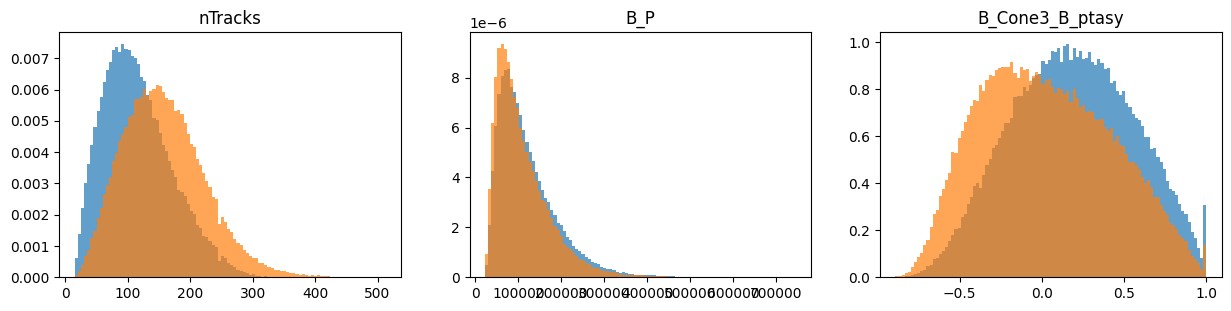

In [5]:
draw_distributions(original, target, original_weights)

In [6]:
print(f'Original train shape: {original_train.shape}')
print(f'Target train shape: {target_train[columns].shape}')
print(f'Original weights train shape: {original_weights_train.shape}')
print(f'Original weights test shape: {original_weights_test.shape}')


Original train shape: (158013, 3)
Target train shape: (110877, 3)
Original weights train shape: (158013,)
Original weights test shape: (52671,)


In [7]:
bins_reweighter = reweight.BinsReweighter(n_bins=20, n_neighs=1.)
bins_reweighter.fit(original_train, target_train[columns], original_weight = original_weights_train, target_weight= target_train['NB0_Kpigamma_sw']  )

BinsReweighter(n_bins=20, n_neighs=1.0)

nTracks
KS over  nTracks  =  0.12115255127920999
B_P
KS over  B_P  =  0.029141729624572232
B_Cone3_B_ptasy
KS over  B_Cone3_B_ptasy  =  0.2529572022897597


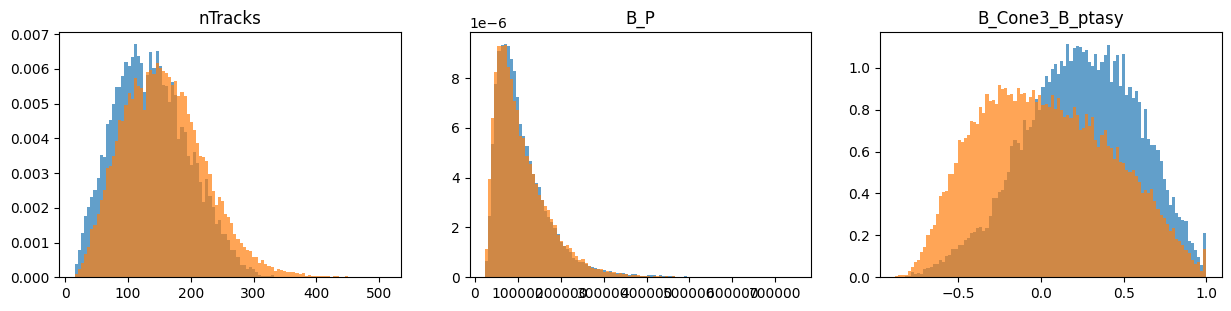

In [8]:
bins_weights_test = bins_reweighter.predict_weights(original_test)
# validate reweighting rule on the test part comparing 1d projections
draw_distributions(original_test, target_test, bins_weights_test)